In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import TextVectorization, LSTM, SimpleRNN, Embedding, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [17]:
df = pd.read_csv("../Data/preprocessed/stance_preprocessed.csv")

In [18]:
def evaluate_model(model_name, y_true, y_pred):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="weighted"),
        "Recall": recall_score(y_true, y_pred, average="weighted"),
        "F1": f1_score(y_true, y_pred, average="weighted")
    }

In [19]:
results = []

In [20]:
df["combined"] = df["headline_prep"].astype(str) + " [SEP] " + df["body_prep"].astype(str)
X = df["combined"].values

In [21]:
le = LabelEncoder()
y = le.fit_transform(df["Stance"])

In [22]:
num_classes = len(le.classes_)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [24]:
max_vocab_size = 20000
max_len = 200
embedding_dim = 64

In [25]:
text_vec = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode="int",
    output_sequence_length=max_len,
    standardize="lower_and_strip_punctuation",
)

In [26]:
text_vec.adapt(X_train)

# Build Simple RNN architecture

In [27]:
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)

In [28]:
x = text_vec(inputs)
x = Embedding(max_vocab_size, embedding_dim)(x)
x = SimpleRNN(64)(x)

In [29]:
outputs = Dense(num_classes, activation="softmax")(x)

In [30]:
model_rnn = tf.keras.Model(inputs, outputs)
model_rnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [31]:
history_rnn = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=128
)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7307 - loss: 0.7890 - val_accuracy: 0.7510 - val_loss: 0.7348
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7654 - loss: 0.6892 - val_accuracy: 0.7655 - val_loss: 0.6943
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7778 - loss: 0.6380 - val_accuracy: 0.7605 - val_loss: 0.7017


In [32]:
y_pred_prob_rnn = model_rnn.predict(X_val)
y_pred_rnn = y_pred_prob_rnn.argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [33]:
model_rnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 200, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,865,550 (14.75 MB)

 Trainable params: 1,288,516 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,577,034 (9.83 MB)

In [34]:
print(history_rnn.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


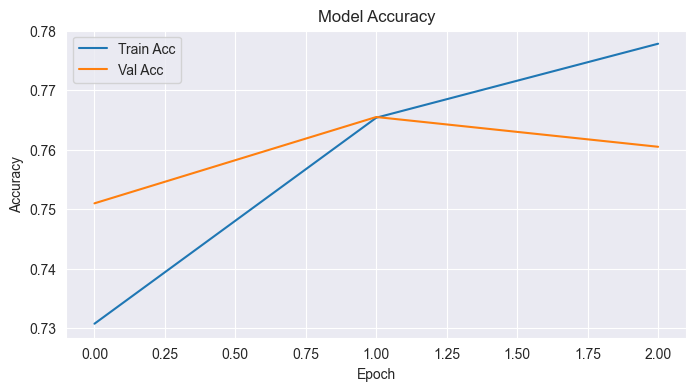

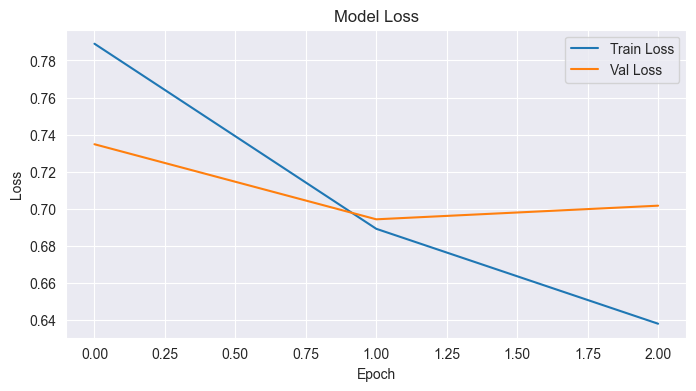

In [35]:
plt.figure(figsize=(8,4))
plt.plot(history_rnn.history['accuracy'], label='Train Acc')
plt.plot(history_rnn.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [36]:
loss, acc = model_rnn.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {acc:.4f}")
print(f"Validation loss: {loss:.4f}")

Validation accuracy: 0.7605
Validation loss: 0.7017


In [37]:
print(classification_report(y_val, y_pred_rnn))
print(confusion_matrix(y_val, y_pred_rnn))

              precision    recall  f1-score   support

           0       0.46      0.06      0.11       736
           1       0.40      0.08      0.14       168
           2       0.62      0.26      0.37      1782
           3       0.78      0.97      0.86      7309

    accuracy                           0.76      9995
   macro avg       0.57      0.34      0.37      9995
weighted avg       0.72      0.76      0.71      9995

[[  47    7   62  620]
 [   8   14    6  140]
 [  26   11  470 1275]
 [  21    3  215 7070]]


In [38]:
metrics_rnn = evaluate_model("Simple RNN", y_val, y_pred_rnn)
metrics_rnn

{'Model': 'Simple RNN',
 'Accuracy': 0.76048024012006,
 'Precision': 0.7197619391695788,
 'Recall': 0.76048024012006,
 'F1': 0.706645434151603}

In [39]:
results.append(metrics_rnn)

# LSTM

In [43]:
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)

In [44]:
x = text_vec(inputs)
x = Embedding(max_vocab_size, embedding_dim)(x)
x = LSTM(64)(x)

In [45]:
outputs = Dense(num_classes, activation="softmax")(x)

In [46]:
model_lstm = tf.keras.Model(inputs, outputs)
model_lstm.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

In [47]:
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=128
)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - accuracy: 0.7385 - loss: 0.7805 - val_accuracy: 0.7631 - val_loss: 0.7029
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.7672 - loss: 0.6760 - val_accuracy: 0.7722 - val_loss: 0.6682
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.7738 - loss: 0.6305 - val_accuracy: 0.7755 - val_loss: 0.6276


In [48]:
y_proba_lstm = model_lstm.predict(X_val)
y_pred_lstm = y_proba_lstm.argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


In [49]:
print(classification_report(y_val, y_pred_lstm))
print(confusion_matrix(y_val, y_pred_lstm))

              precision    recall  f1-score   support

           0       0.59      0.07      0.13       736
           1       0.38      0.11      0.17       168
           2       0.67      0.36      0.46      1782
           3       0.79      0.96      0.87      7309

    accuracy                           0.78      9995
   macro avg       0.61      0.37      0.41      9995
weighted avg       0.75      0.78      0.73      9995

[[  52   14   63  607]
 [   8   18    8  134]
 [  19    9  636 1118]
 [   9    6  249 7045]]


In [50]:
metrics_lstm = evaluate_model("LSTM", y_val, y_pred_lstm)
metrics_lstm

{'Model': 'LSTM',
 'Accuracy': 0.775487743871936,
 'Precision': 0.747150811341162,
 'Recall': 0.775487743871936,
 'F1': 0.7304472272146533}

In [51]:
results.append(metrics_lstm)

# BiLSTM

In [56]:
inputs = tf.keras.Input(shape=(), dtype=tf.string)

In [57]:
x = text_vec(inputs)
x = Embedding(max_vocab_size, embedding_dim)(x)
x = Bidirectional(LSTM(64))(x)

In [58]:
outputs = Dense(num_classes, activation="softmax")(x)

In [59]:
model_bilstm = tf.keras.Model(inputs, outputs)
model_bilstm.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

In [60]:
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=128
)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 128ms/step - accuracy: 0.7575 - loss: 0.6724 - val_accuracy: 0.7991 - val_loss: 0.5264
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.8340 - loss: 0.4453 - val_accuracy: 0.8415 - val_loss: 0.4353
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 139ms/step - accuracy: 0.8694 - loss: 0.3603 - val_accuracy: 0.8551 - val_loss: 0.3907


In [61]:
y_pred_prob_bilstm = model_bilstm.predict(X_val)
y_pred_bilstm = y_pred_prob_bilstm.argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


In [62]:
print(classification_report(y_val, y_pred_bilstm))
print(confusion_matrix(y_val, y_pred_bilstm))

              precision    recall  f1-score   support

           0       0.60      0.55      0.57       736
           1       0.52      0.21      0.30       168
           2       0.74      0.75      0.74      1782
           3       0.91      0.93      0.92      7309

    accuracy                           0.86      9995
   macro avg       0.69      0.61      0.63      9995
weighted avg       0.85      0.86      0.85      9995

[[ 407   25   60  244]
 [  76   35   14   43]
 [  61    5 1329  387]
 [ 137    2  394 6776]]


In [63]:
metrics_bilstm = evaluate_model("Bidirectional LSTM", y_val, y_pred_bilstm)
metrics_bilstm

{'Model': 'Bidirectional LSTM',
 'Accuracy': 0.8551275637818909,
 'Precision': 0.8497543496507516,
 'Recall': 0.8551275637818909,
 'F1': 0.8511791449615023}

In [64]:
results.append(metrics_bilstm)

# BiSimple RNN

In [65]:
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)

In [66]:
x = text_vec(inputs)
x = Embedding(max_vocab_size, embedding_dim)(x)
x = Bidirectional(SimpleRNN(64))(x)

In [67]:
outputs = Dense(num_classes, activation="softmax")(x)

In [69]:
model_birnn = tf.keras.Model(inputs, outputs)

In [70]:
model_birnn.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

In [71]:
history_birnn = model_birnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=128
)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7289 - loss: 0.7741 - val_accuracy: 0.7411 - val_loss: 0.7086
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.7607 - loss: 0.6586 - val_accuracy: 0.7675 - val_loss: 0.6459
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.7825 - loss: 0.5715 - val_accuracy: 0.7615 - val_loss: 0.6343


In [72]:
y_proba_birnn = model_birnn.predict(X_val)
y_pred_birnn = y_proba_birnn.argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [73]:
print(classification_report(y_val, y_pred_birnn))
print(confusion_matrix(y_val, y_pred_birnn))

              precision    recall  f1-score   support

           0       0.42      0.20      0.27       736
           1       0.44      0.12      0.19       168
           2       0.68      0.29      0.40      1782
           3       0.78      0.95      0.86      7309

    accuracy                           0.76      9995
   macro avg       0.58      0.39      0.43      9995
weighted avg       0.73      0.76      0.72      9995

[[ 145   14   40  537]
 [  12   20    6  130]
 [  13    6  511 1252]
 [ 175    5  194 6935]]


In [74]:
metrics_birnn = evaluate_model("Bidirectional RNN", y_val, y_pred_birnn)
metrics_birnn

{'Model': 'Bidirectional RNN',
 'Accuracy': 0.7614807403701851,
 'Precision': 0.7325042343783231,
 'Recall': 0.7614807403701851,
 'F1': 0.7223691303130123}

In [75]:
results.append(metrics_birnn)

# Results

In [76]:
df_results_deep = pd.DataFrame(results)
df_results_deep

,Model,Accuracy,Precision,Recall,F1
0,Simple RNN,0.760480,0.719762,0.760480,0.706645
1,LSTM,0.775488,0.747151,0.775488,0.730447
2,Bidirectional LSTM,0.855128,0.849754,0.855128,0.851179
3,Bidirectional RNN,0.761481,0.732504,0.761481,0.722369


In [77]:
df_melt_deep = df_results_deep.melt(
    id_vars="Model",
    var_name="Metric",
    value_name="Score"
)

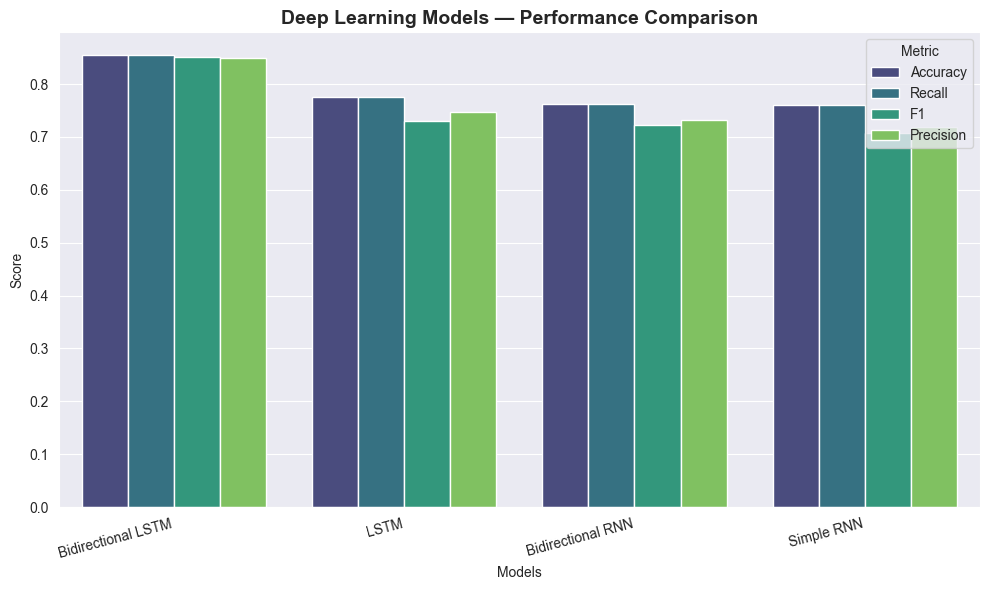

In [79]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_melt_deep.sort_values(by="Score", ascending=False),
    x="Model",
    y="Score",
    hue="Metric",
    palette="viridis"
)
plt.title("Deep Learning Models — Performance Comparison", fontsize=14, weight='bold')
plt.xticks(rotation=15, ha="right")
plt.ylabel("Score")
plt.xlabel("Models")
plt.tight_layout()
plt.savefig("../images/DeepLearning-Comparison.png")
plt.show()